<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Visualising-some-data-from-the-LOPEX'93-dataset" data-toc-modified-id="Visualising-some-data-from-the-LOPEX'93-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualising some data from the LOPEX'93 dataset</a></span><ul class="toc-item"><li><span><a href="#Comments" data-toc-modified-id="Comments-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comments</a></span></li></ul></li><li><span><a href="#Model-inversion" data-toc-modified-id="Model-inversion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model inversion</a></span><ul class="toc-item"><li><span><a href="#Simple-PROSPECT-inversion" data-toc-modified-id="Simple-PROSPECT-inversion-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Simple PROSPECT inversion</a></span><ul class="toc-item"><li><span><a href="#Some-exercises..." data-toc-modified-id="Some-exercises...-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Some exercises...</a></span></li></ul></li></ul></li><li><span><a href="#Final-remarks" data-toc-modified-id="Final-remarks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final remarks</a></span></li></ul></div>

<div style="float:right">
    <table>
    <tr>
        <td> <img src="../figs/pangeos-small-1.png" alt="PANGEOS" style="width:200px;height:45px;"/> 
        <td> <img src="../figs/kcl_logo.png" alt="King's College London" style="width:54px;height:40px;"/> 
        <td> <img src="../figs/nceo_logo.png" alt="NCEO" style="width:200px;height:40px;"/> 
        <td> <img src="../figs/multiply_logo.png" alt="H2020 Multiply" style="width:40px;height:40px;"/>
    </tr>
    </table>
</div>
&nbsp;

# Fitting some leaf transmittance and reflectance spectral using PROSPECT

**Author:** Jose Gómez-Dans (NCEO & UCL)  `jose.gomez-dans@kcl.ac.uk`



## Introduction

While you might be familiar with statistical inference studies that aim to map magnitudes of interest from data, having a physical model that describes the different processes that give rise to your measurements is in many cases a far more robust way of infering the properties of (in this case) leaves than a purely statistical approach. We will consider a simple cost function minimisation for the time being, and use this explore and gain some intuition in the area of *inverse problems*. 



In [1]:
%load_ext autoreload
%autoreload 2

from pangeos_uq.prosail_funcs import optimise_random_starts
from pangeos_uq.prosail_funcs import read_lopex_sample
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize

import ipywidgets as widgets

## Visualising some data from the LOPEX'93 dataset

The [LOPEX'93 dataset](https://data.ecosis.org/dataset/13aef0ce-dd6f-4b35-91d9-28932e506c41/resource/4029b5d3-2b84-46e3-8fd8-c801d86cf6f1/download/leaf-optical-properties-experiment-93-lopex93.pdf) has been widely used. It contains carefully measured sets of leaf reflectance and transmittance for a number of samples. Each sample contains five replicates. The widget below allows you to plot these samples. Note that some of the samples may be missing. Just skip over to another one!

```{warning}
The widget below will plot the same plots twice... It is a known bug!
```


In [32]:
_ = widgets.interact(read_lopex_sample,
                  sample_no=widgets.IntSlider(min=1, max=116, value=23))
refl, trans = read_lopex_sample.data



interactive(children=(IntSlider(value=23, description='sample_no', max=116, min=1), Checkbox(value=True, descr…

### Comments

Note that after running the previous widget, the reflectance and transmittance values are stored in the variables `refl` and `trans`. These will be used later!

* Can you recognise some features of these samples? Eg absorption features
* What can you say about the replicates and our ability to measure spectra?
* Are there some regions of the spectrum that appear more problematic than others?
* How can you reconcile these five replicates with uncertainty in the measurements?

## Model inversion

The problem at hand is that we want to estimate, from a set of leaf reflectance and transmittance measurements over the solar reflective domain, the PROSPECT input parameters that result in the measurements. Since our model is able to predict the observations, the obvious thing to do is to *minimise the difference* between predictions and observations. So $M_{\rho}(\mathbf{x}, \lambda)$ and $M_{\tau}(\mathbf{x}, \lambda)$ represent the predicted reflectance and transmittance (respectively) calculated by PROSPECT with an input vector $\mathbf{x}$ (where $\mathbf{x}=\left[ N, Cab, Car, Csen, Cw,Cm\right]$) at a wavelength $\lambda$. The measurements will be denoted by $\rho(\lambda)$ and $\tau(\lambda)$, for refletance and transmittance (respectively). The least squares problem is then given by the minimisation of $J(\mathbf{x})$:

$$
J(\mathbf{x}) = \frac{1}{2}\sum_{\lambda=400\,nm}^{2500\,nm} \left[ M_{\rho}(\mathbf{x}, \lambda) - \rho(\lambda)  \right]^{2} + \frac{1}{2}\sum_{\lambda=400\,nm}^{2500\,nm} \left[ M_{\tau}(\mathbf{x}, \lambda) - \tau(\lambda)  \right]^{2}.
$$

In reality, we ought to weight the cost by **the uncertainty**. In the absence of more information, we can assume that each spectral 1 nm band has additive Gaussian noise given by a variance $\sigma_{\rho}^2$ or $\sigma_{\tau}^2$ (reflectance and transmittance respectively). This assumes that spectrally adjacent measurements aren't correlated. Before we delve with that case, let's see how the previous cost function would look like:

$$
J(\mathbf{x}) = \frac{1}{2}\sum_{\lambda=400\,nm}^{2500\,nm} \left[ \frac{M_{\rho}(\mathbf{x}, \lambda) - \rho(\lambda)}{\sigma_{\rho}(\lambda)^2}  \right]^{2} + \frac{1}{2}\sum_{\lambda=400\,nm}^{2500\,nm} \left[ \frac{M_{\tau}(\mathbf{x}, \lambda) - \tau(\lambda) }{\sigma_{\tau}(\lambda)^2} \right]^{2}.
$$

In this expression we are assuming independence of spectral measurements and also of measurement type (both reflectance and transmittance at $\lambda$ are uncorrelated). This is hardly ever the case, so perhaps a more realistic cost function could be modelled by assuming that a vector of simulated reflectance and transmittance observations have a multivariate Gaussian distribution with a covariance matrix $\mathcal{C}$. Note that we have 2100 measurements for reflectance and 2100 for transmittance, so the covariance matrix is $4200\times 4200$. This is a big matrix, and note that we will have to invert it. This is a computationally expensive operation, and we will have to be careful with it.

Denoting by $M(\mathbf{x})$ the vector that stacks all the reflectance and transmittance values, and $\vec{y}$ the vector that stacks all the measurements, we can write the cost function as:

$$
J(\mathbf{x}) = \frac{1}{2} \left( M(\mathbf{x}) - \vec{y} \right)^{\top} \mathcal{C}^{-1} \left( M(\mathbf{x}) - \vec{y} \right).
$$

This latter formulation is a more general one. The previous formulations are special cases of this one. We will start by assuming independence of measurements, and see what information is contained in the reflectance/transmittance data. In a follow-up notebook, we'll explore what the simplifications mean in terms of retrieved parameters.


### Simple PROSPECT inversion

We will be using some leaf spectra either from the field, or from the LOPEX'93 database. We provide you with two Python functions:

* **``read_lopex_sample``** reads a particular sample from the LOPEX database. Each sample has 5 replicates.
* **``optimise_random_starts``** minimises the cost function $J(\mathbf{x})$ using a set of reflectance and transmittance measurements. We assume that there's no spectral correlation and that reflectance and trasnmitance are uncorrelated. 

The function ``optimise_random_starts`` minimises the cost function using a gradient descent algorithm. The function will return the best estimate of the parameters, the cost function value at that point, and the number of iterations. One problem with gradient descent is that it is a **local optimiser**, and the solution will depend on the starting point. The provided function will start the minimisation in ten different randomly-chosen starting points in parameter space to account for this, but note that this is only a heuristic, and not a strong guarantee that the solution is the global minimum!!!!


``optimise_random_starts`` allows you to pass reflectance and/or transmittance and will start the minimisation in ten different randomly-chosen starting points in parameter space. You can also code up your own cost function and pass it to the main function if you want to change how the cost function is calculated.

You can use the `refl` and `trans` variables from the previous GUI. The first element is the replicate (0 to 4), or you can average all the values with `refl.mean(axis=0)` or `trans.mean(axis=0)`.


,n,cab,car,cbrown,cw,cm,cost
0,1.429689,47.029977,15.118508,0.163201,0.008401,0.007179,0.258404
1,1.429912,44.235873,18.102150,0.187094,0.008420,0.007142,0.279918
2,1.429675,46.834280,16.379027,0.163445,0.008401,0.007180,0.264892
3,1.429657,47.194287,15.682099,0.160935,0.008399,0.007183,0.261226
4,1.430000,44.960000,12.377861,0.188742,0.008424,0.007134,0.251262
5,1.429821,47.344724,11.283568,0.167832,0.008407,0.007167,0.243544
6,1.429832,47.997021,9.314823,0.168550,0.008410,0.007162,0.240904
7,1.429796,50.430877,6.052199,0.163138,0.008410,0.007161,0.252494
8,1.429463,52.420583,8.417481,0.133551,0.008382,0.007217,0.252195
9,1.429822,47.998137,9.317362,0.168489,0.008410,0.007162,0.240904


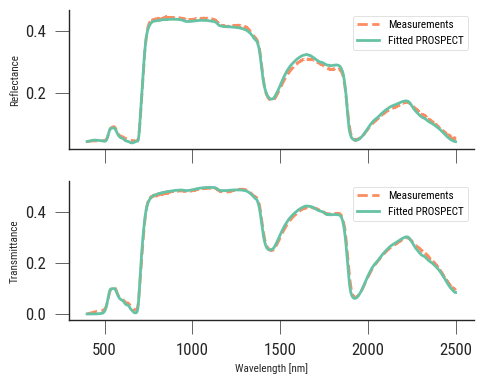

In [3]:
(df_rho_tau_sols, _, _,) = optimise_random_starts(
    refl[0, :], trans[0, :], verbose=False
)
df_rho_tau_sols


,n,cab,car,cbrown,cw,cm,cost
0,1.453762,47.805951,14.459171,0.164918,0.008966,0.007436,0.098709
1,1.461080,64.231333,7.199974,0.084047,0.008884,0.007784,0.124596
2,1.453934,50.851355,7.488813,0.155769,0.008962,0.007448,0.094735
3,1.453149,46.633305,15.234294,0.172900,0.008975,0.007404,0.100488
4,1.449242,40.582265,16.163149,0.223817,0.009033,0.007193,0.117505
5,1.453579,49.559545,9.009643,0.160395,0.008965,0.007433,0.093996
6,1.458476,56.765537,11.648163,0.113328,0.008911,0.007664,0.105818
7,1.453875,48.990550,11.517469,0.159644,0.008962,0.007447,0.095193
8,1.453577,49.559703,9.009913,0.160398,0.008965,0.007433,0.093996
9,1.453937,48.793040,12.311598,0.159997,0.008961,0.007449,0.095953


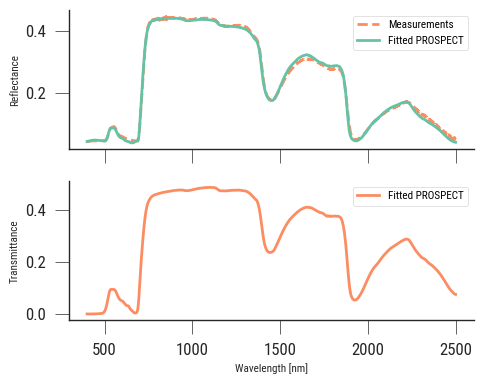

In [4]:
(df_rho_sols, _, _,) = optimise_random_starts(
    refl[0, :], None, verbose=False, n_tries=10,
)
df_rho_sols

,n,cab,car,cbrown,cw,cm,cost
0,1.454939,46.976640,9.372065,0.170317,0.008127,0.006885,0.117559
1,1.455016,46.845546,9.934636,0.168922,0.008125,0.006886,0.117726
2,1.454465,47.582401,7.267989,0.177121,0.008135,0.006878,0.120357
3,1.453630,50.351818,5.843926,0.159967,0.008126,0.006911,0.128408
4,1.455151,46.059816,16.292352,0.159333,0.008115,0.006905,0.134307
5,1.455117,46.677359,11.207040,0.165335,0.008122,0.006891,0.119182
6,1.455602,44.219652,12.815978,0.187425,0.008135,0.006856,0.125148
7,1.455150,46.557847,12.642536,0.161891,0.008118,0.006898,0.122254
8,1.455099,46.666983,14.291417,0.156592,0.008114,0.006907,0.127190
9,1.454939,46.976563,9.371500,0.170320,0.008127,0.006885,0.117559


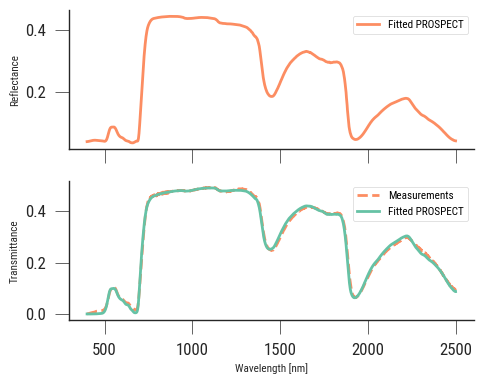

In [5]:
(df_tau_sols, _, _,) = optimise_random_starts(
    None, trans[0, :], verbose=False, n_tries=10,
)
df_tau_sols

#### Some exercises...

* Try the above inversions for a couple of different samples, and try several of the replicates for each sample. Compare the results, what do you see?
* You can also compare the results if using only reflectance or only transmittance.
* You can just invert each replicate independently with a simple loop. Something like this may work

```python

for i in range(5):
    print("==================================================================")
    print("===========================> Replicate %d <==========================="%(i+1))
    retval = optimise_random_starts (refl[i, :], trans[i, :], do_plots=False);
    # Switch off plotting
    # Can also set n_tries to a different value to do more or less random starting points
```
* Look at the results of the parameters over these 5 replicates and 10 random starting points. Do you notice anything interesting?
* What if you only use reflectance rather than both reflectance and transmittance?
* The five replicates are typically fairly noisy. We can take their difference as a statement of the **measurement uncertainty**. Can you suggest a way how you could modify the cost function in order to account for this? Here's how the cost function currently looks like:

```python
def cost_function ( x, refl, trans ):
    """Calculates a cost function using PROSPECT predictions and refl and trans data.
    Parameters
    ----------
    x: array
       A 6-element array, with the following order: 
       n, cab, car, cbrown, cw, cm 
    refl: array
        A 2101 element array with leaf reflectance (400-2500 nm).
        Can be `None` if not used/available.
    trans: array
        A 2101 element array with leaf tarnsmitance (400-2500 nm)
        Can be `None` if not used/available.
        
    Returns
    -------
    The sum of squared differences between model and observations
    """
    retval = call_prospect_5 ( *x )
    if refl is None:
        cost_refl = 0.
    else:
        cost_refl = ( refl - retval[ :, 0])**2
    if trans is None:
        cost_trans = 0.
    else:
        cost_trans = ( trans - retval[ :, 1])**2
    return np.sum ( cost_refl  + cost_trans )
```
* Uncertaint inputs certainly suggest uncertain outputs! Can you think of a way in which we could estimate the uncertainty in the outputs as a function of input uncertainty? 


## Final remarks

The previous example you have explored how to fit the PROSPECT model to some measurements of reflectance and transmittance from the LOPEX'93 datasets. We have seen that the starting points decision is important: in some cases, the minimisation does not converge, but in general, there are many "acceptable minima". 

We have seen that the inversion is quite unstable when changing the replicates due to measurement error. The implication here is that a number of replicates for each sample are needed to assess the measurement noise. We have also seen that using both reflectance and transmittance tends to result in better (meaning more stable) results.

There are other observations to bear in mind. One is that the parameters of the PROSPECT model vary over several orders of magnitude. This will always present a challenge to a function optimiser like the one we're using. A better way of proceeding would be to rescale all parameters to be of the same broad magnitude. We have also assumed that each spectral 1 nm bin is independent of each other. This is unlikely, so this will probably result in over-confident inversions.

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.